# Example pre-processing for MEG and EEG T-maze data

### Import all libraries

In [233]:
import os
import numpy as np

import matplotlib.pyplot as plt

import mne
from mne.preprocessing import ICA
from mne.time_frequency import tfr_morlet

### Load the data and get an idea of the raw files

In [234]:
# Set the directory and file name
sample_data_folder = 'D:\\MEGEEG_project\\MEG\\Data\\Backup\\'
sample_data_raw_file = os.path.join(sample_data_folder, '0001_Maze_20061022_06.ds')
montage = mne.channels.make_standard_montage(kind='standard_1005')

# Read the file
raw = mne.io.read_raw_ctf(sample_data_raw_file, preload=True)

ds directory : D:\MEGEEG_project\MEG\Data\Backup\0001_Maze_20061022_06.ds
    res4 data read.
    hc data read.
    Separate EEG position data file read.
    Quaternion matching (desired vs. transformed):
      -7.88   67.27    0.00 mm <->   -7.88   67.27    0.00 mm (orig :  -41.66   55.67 -276.85 mm) diff =    0.000 mm
       7.88  -67.27   -0.00 mm <->    7.88  -67.27    0.00 mm (orig :   69.57  -21.28 -269.46 mm) diff =    0.000 mm
      80.83    0.00    0.00 mm <->   80.83   -0.00    0.00 mm (orig :   66.47   77.62 -261.99 mm) diff =    0.000 mm
    Coordinate transformations established.
    Polhemus data for 3 HPI coils added
    Device coordinate locations for 3 HPI coils added
    6 EEG electrode locations assigned to channel info.
    6 EEG locations added to Polhemus data.
    Measurement info composed.
Finding samples for D:\MEGEEG_project\MEG\Data\Backup\0001_Maze_20061022_06.ds\0001_Maze_20061022_06.meg4: 
    System clock channel is available, checking which samples are v

In [235]:
# For setting the EEG montage, first identify the eog channels which cannot be recognized from standard digital montage names
raw.set_channel_types({'Saccade': 'eog', 'EEG031': 'eog'})
# Set positions based on names (Fz, Cz, M1, M2) and ignore the two eog channels (missing montage positions allowed)
raw.set_montage(montage=montage, on_missing='ignore')

<RawCTF | 0001_Maze_20061022_06.meg4, 191 x 288000 (480.0 s), ~420.2 MB, data loaded>

## Review some basic properties of the file

In [238]:
n_time_samps = raw.n_times
time_secs = raw.times
ch_names = raw.ch_names
n_chan = len(ch_names)

print('The sample data object has {} time samples and {} channels.'
      ''.format(n_time_samps, n_chan))
print('The last time sample is at {} seconds.'.format(time_secs[-1]))
print('The first few channel names are {}.'.format(', '.join(ch_names[:3])))
print()  # insert a blank line in the output
print('Bad channels:', raw.info['bads'])  # chs marked "bad" during acquisition
print('Sampling rate: ', raw.info['sfreq'], 'Hz')            # sampling frequency

The sample data object has 288000 time samples and 191 channels.
The last time sample is at 479.99833333333333 seconds.
The first few channel names are STIM, SCLK01-177, BG1-2511.

Bad channels: []
Sampling rate:  600.0 Hz


In [240]:
# Here is some more detailed info extracted from the file
print(raw.info)

<Info | 16 non-empty values
 bads: []
 ch_names: STIM, SCLK01-177, BG1-2511, BG2-2511, BG3-2511, BP1-2511, ...
 chs: 1 STIM, 1 MISC, 32 REF_MEG, 151 MAG, 4 EEG, 2 EOG
 comps: 5 items (list)
 ctf_head_t: CTF/4D/KIT head -> head transform
 custom_ref_applied: False
 dev_ctf_t: MEG device -> CTF/4D/KIT head transform
 dev_head_t: MEG device -> head transform
 dig: 7 items (3 Cardinal, 4 EEG)
 experimenter: Teresa
 highpass: 0.0 Hz
 hpi_results: 1 item (list)
 lowpass: 300.0 Hz
 meas_date: 2006-10-22 13:39:57 UTC
 meas_id: 4 items (dict)
 nchan: 191
 projs: []
 sfreq: 600.0 Hz
 subject_info: 1 item (dict)
>


C:\Users\Malte\Anaconda2\envs\mne\lib\site-packages\matplotlib\colors.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  c = np.array(c)


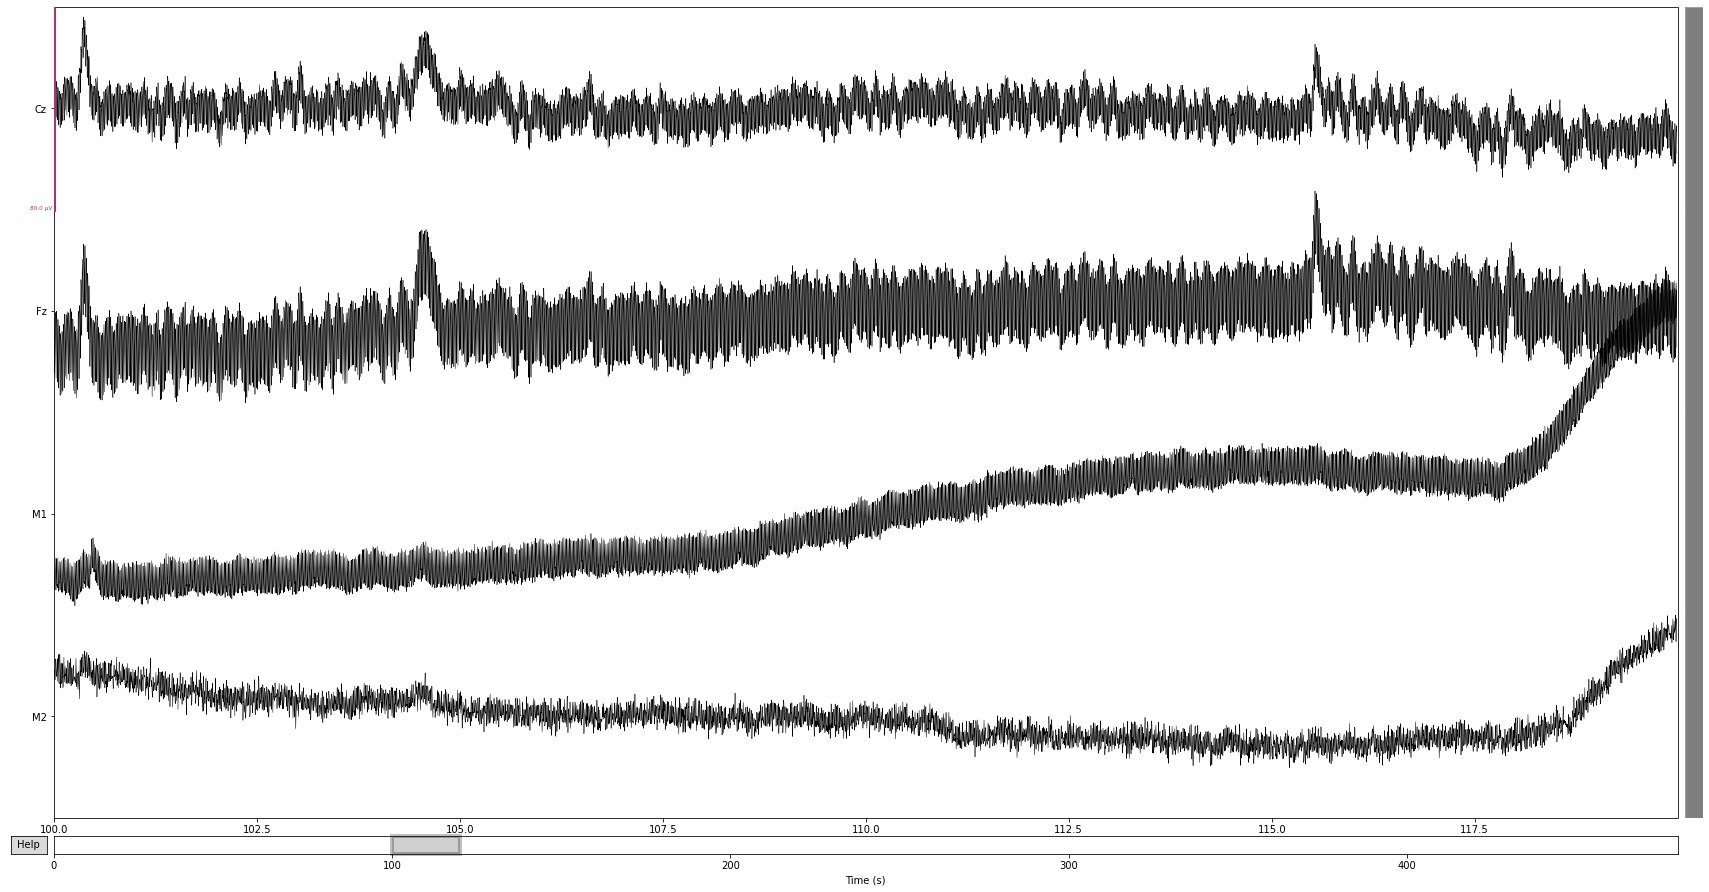

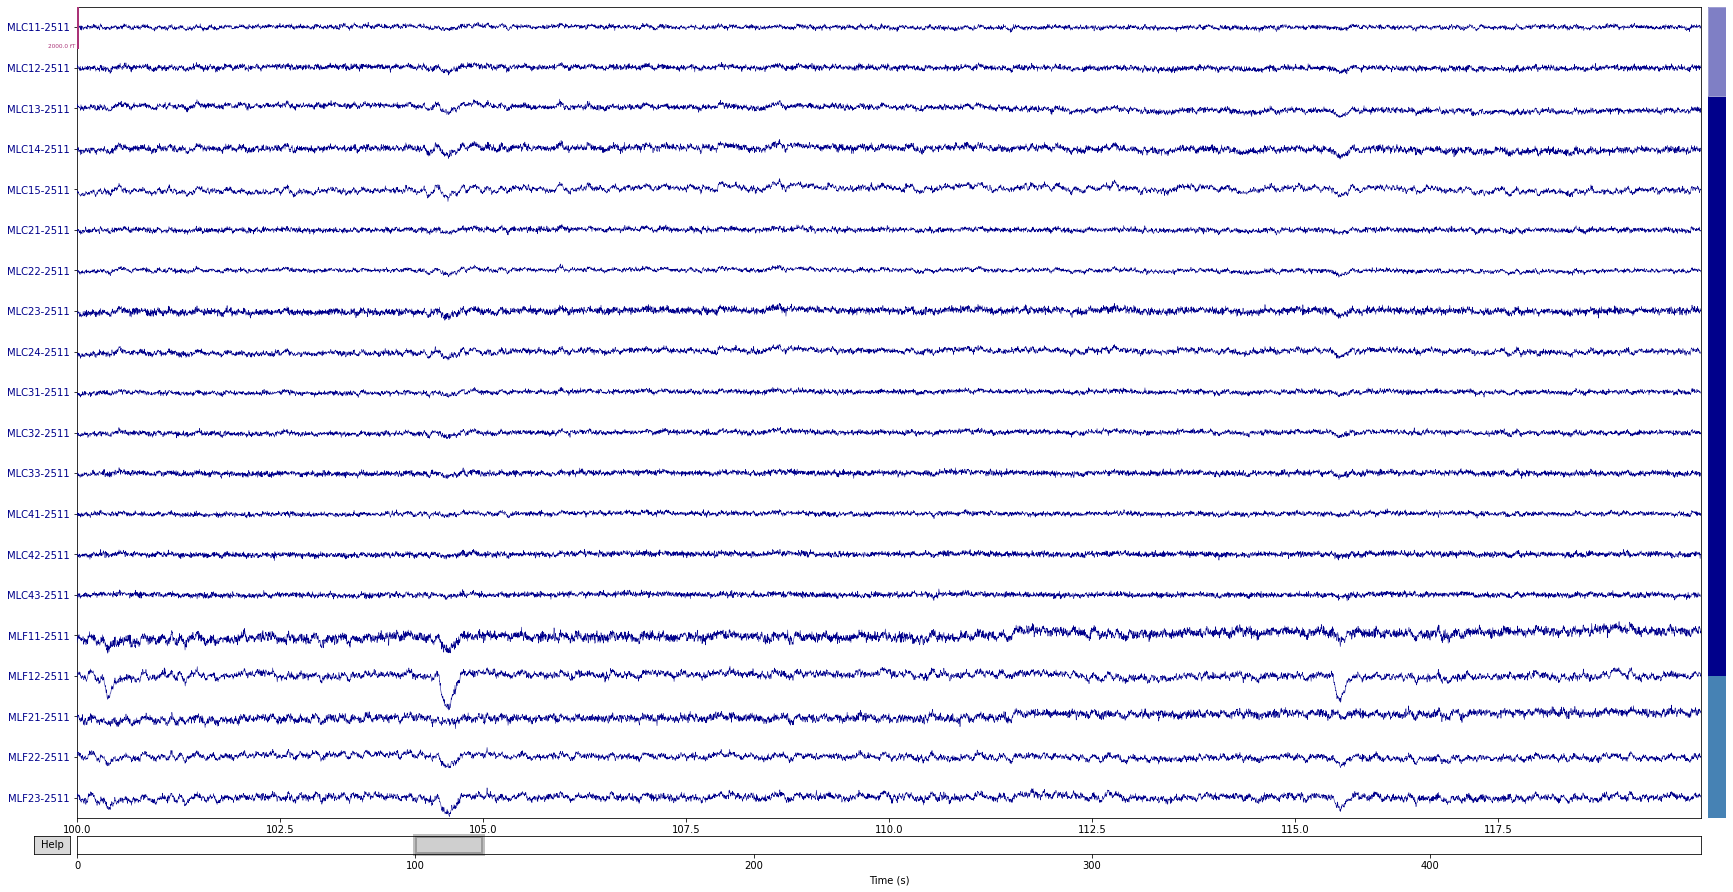

In [241]:
# Let's look at 20 seconds after 100 s of all the MEG and EEG channels
# Set the channel names of type eeg and meg
picks_eeg = raw.copy().pick_types(eeg=True, meg=False)
picks_meg = raw.copy().pick_types(meg=True, eeg=False)
# Create a dictionary with the scales for EEG (80 microV) and MEG (2000 ft)
scaling = dict(mag=1e-12, eeg=40e-6)

# Titles for plots
EEG = 'EEG channels'
MEG = 'MEG channels'

# Here is EEG ...
raw.copy().pick_channels(picks_eeg.ch_names).plot(start=100, duration=20, scalings=scaling, title=EEG);
# ... and here MEG
raw.copy().pick_channels(picks_meg.ch_names).plot(start=100, duration=20, scalings=scaling, title=MEG);

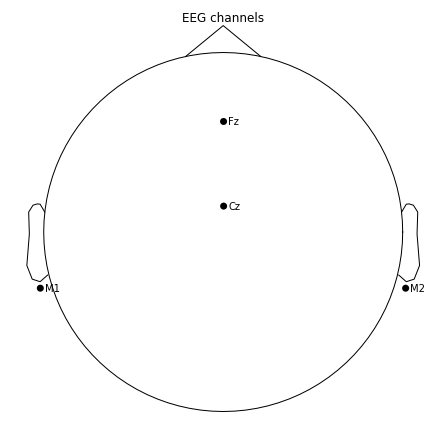

Removing 5 compensators from info because not all compensation channels were picked.


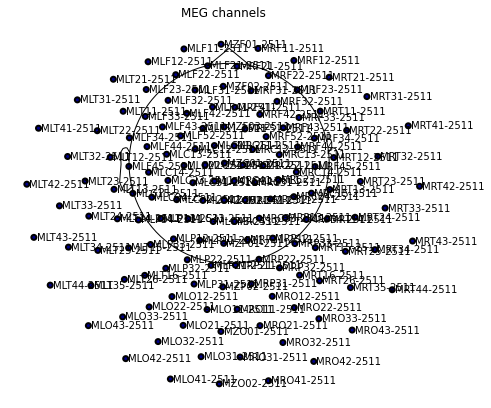

In [242]:
# Plot the sensor maps, again for both ...
# ... EEG ...
raw.plot_sensors(kind='topomap', ch_type='eeg', show_names=True, title=EEG);
# ... and MEG
raw.plot_sensors(kind='topomap', ch_type='mag', show_names=True, title=MEG);

## Next is the event structure and presumable event code mappings

400 events found
Event IDs: [ 65536 131072 262144 327680 393216 458752 524288 589824]


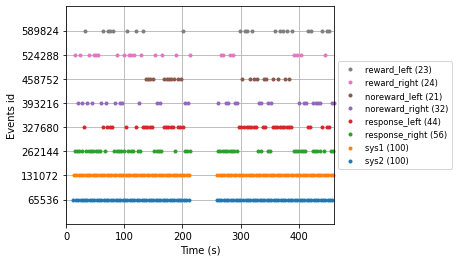

C:\Users\Malte\Anaconda2\envs\mne\lib\site-packages\matplotlib\colors.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  c = np.array(c)


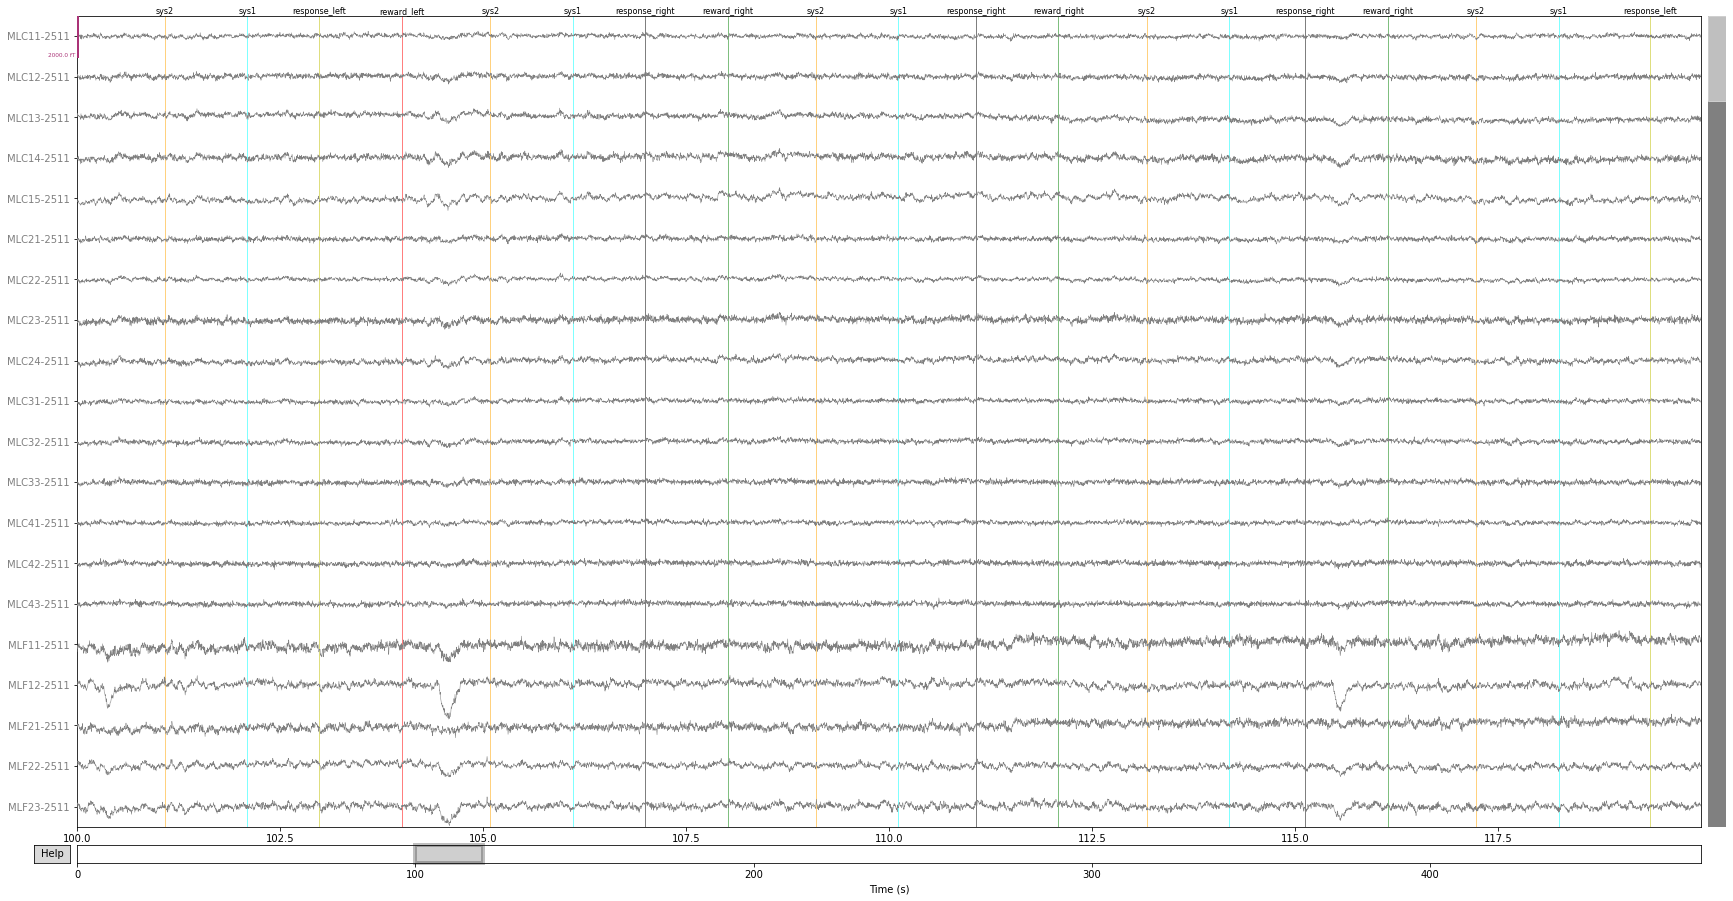

In [243]:
# First, build a dictionary of event ids
# This is my presumable event mapping based on frequencies I found
event_id = {'reward_left': 589824, 'reward_right': 524288, 'noreward_left': 458752, 'noreward_right': 393216,
            'response_left': 327680, 'response_right': 262144, 'sys1': 131072, 'sys2': 65536}

# Read the events from the stimulus channel
events = mne.find_events(raw, stim_channel='STIM', min_duration=.01)
# Plot all events across time
fig = mne.viz.plot_events(events, raw.info['sfreq'],
                          event_id=event_id, first_samp=raw.first_samp)
fig.subplots_adjust(right=0.7)

# Let's see that in the raw data (again after 100 s for 20 s)
raw.plot(events=events, start=100, duration=20, color='gray', event_id=event_id,
         event_color={589824: 'r', 524288: 'g', 458752: 'b', 393216: 'm', 327680: 'y', 262144: 'k',
                      131072: 'cyan', 65536: 'orange'});

## Pre-processing

Effective window size : 3.413 (s)
Effective window size : 3.413 (s)


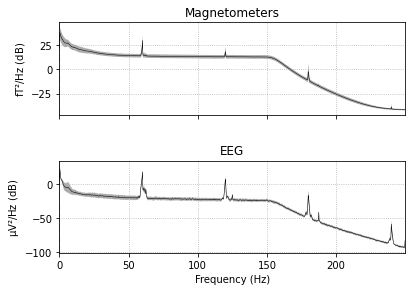

In [244]:
# For a start, plotting two types of prevalent artifacts
# Starting with power line noise (persistent oscillations centered around 
# AC power line frequency (typically around 50 Hz and 60 Hz)
# Plot the power spectral density with arrows pointing to likely power line noise
fig = raw.plot_psd(tmax=np.inf, fmax=250, average=True)
for ax in fig.axes[:2]:
    freqs = ax.lines[-1].get_xdata()
    psds = ax.lines[-1].get_ydata()
    for freq in (60, 120, 180, 240):
        idx = np.searchsorted(freqs, freq)
        ax.arrow(x=freqs[idx], y=psds[idx] + 18, dx=0, dy=-12, color='red',
                 width=0.1, head_width=3, length_includes_head=True)

EOG channel index for this subject is: [189 190]
Filtering the data to remove DC offset to help distinguish blinks from saccades
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 6000 samples (10.000 sec)

Now detecting blinks and generating corresponding events
Found 110 significant peaks
Number of EOG events detected : 110
Not setting metadata
Not setting metadata
110 matching events found
Applying baseline correction (mode: mean)
Loading data for 110 events and 601 original time points ...
1 bad epochs dropped
No projector specified for this dataset. Please consider the method sel

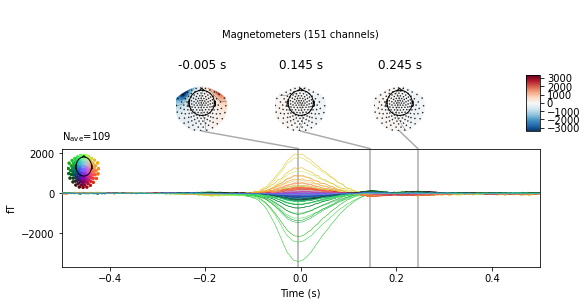

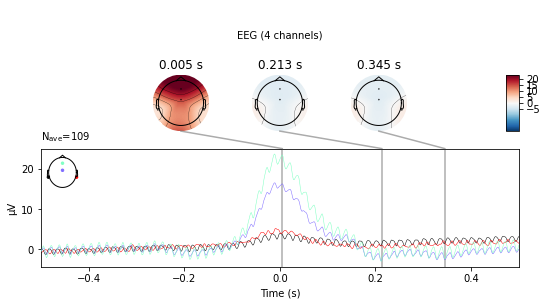

[<Figure size 576x302.4 with 7 Axes>, <Figure size 576x302.4 with 7 Axes>]

In [245]:
# Next, let's look at ocular artifacts as evident from the EOG (channels are automatically detected if channel types have been defined correctly)
eog_epochs = mne.preprocessing.create_eog_epochs(raw, baseline=(-0.5, -0.2))
eog_epochs.average().plot_joint()

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 60 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 60.00 Hz
- Upper transition bandwidth: 15.00 Hz (-6 dB cutoff frequency: 67.50 Hz)
- Filter length: 1981 samples (3.302 sec)

Effective window size : 3.413 (s)
Effective window size : 3.413 (s)


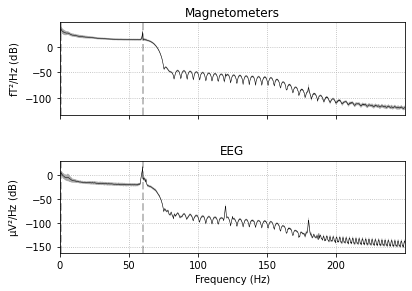

In [246]:
# To tackle the first problem (power line noise and slow drifts), filter the data
filter_raw = raw.copy()
filter_raw.filter(l_freq=1, h_freq=60, fir_window='hamming', method='fir')
# Create the same plot from before (dotted lines indicate filter low pass cut-off)
fig = filter_raw.plot_psd(tmax=np.inf, fmax=250, average=True)
for ax in fig.axes[:2]:
    freqs = ax.lines[-1].get_xdata()
    psds = ax.lines[-1].get_ydata()
    for freq in (60, 120, 180, 240):
        idx = np.searchsorted(freqs, freq)
        ax.arrow(x=freqs[idx], y=psds[idx] + 18, dx=0, dy=-12, color='red',
                 width=0.1, head_width=3, length_includes_head=True)

In [248]:
# For the ocular artifacts, employ an ICA correction approach
# Set parameters for ICA
n_components = 15
method='infomax'
allow_ref_meg = False

ica = ICA(n_components=n_components, method=method, allow_ref_meg=allow_ref_meg)
ica.fit(filter_raw)

Fitting ICA to data using 155 channels (please be patient, this may take a while)
Removing 5 compensators from info because not all compensation channels were picked.
Selecting by number: 15 components
 


C:\Users\Malte\Anaconda2\envs\mne\lib\site-packages\mne\preprocessing\infomax_.py:192: RuntimeWarning: overflow encountered in exp
  y = 1.0 / (1.0 + np.exp(-u))


Fitting ICA took 38.3s.


<ICA | raw data decomposition, fit (infomax): 288000 samples, 15 components, channels used: "mag"; "eeg">

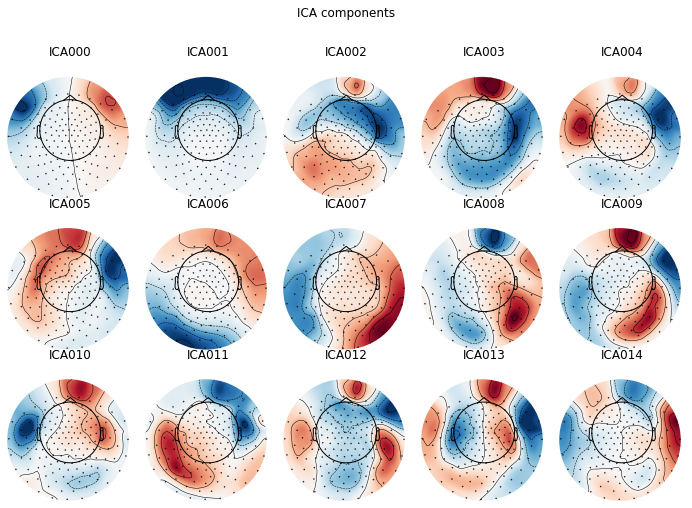

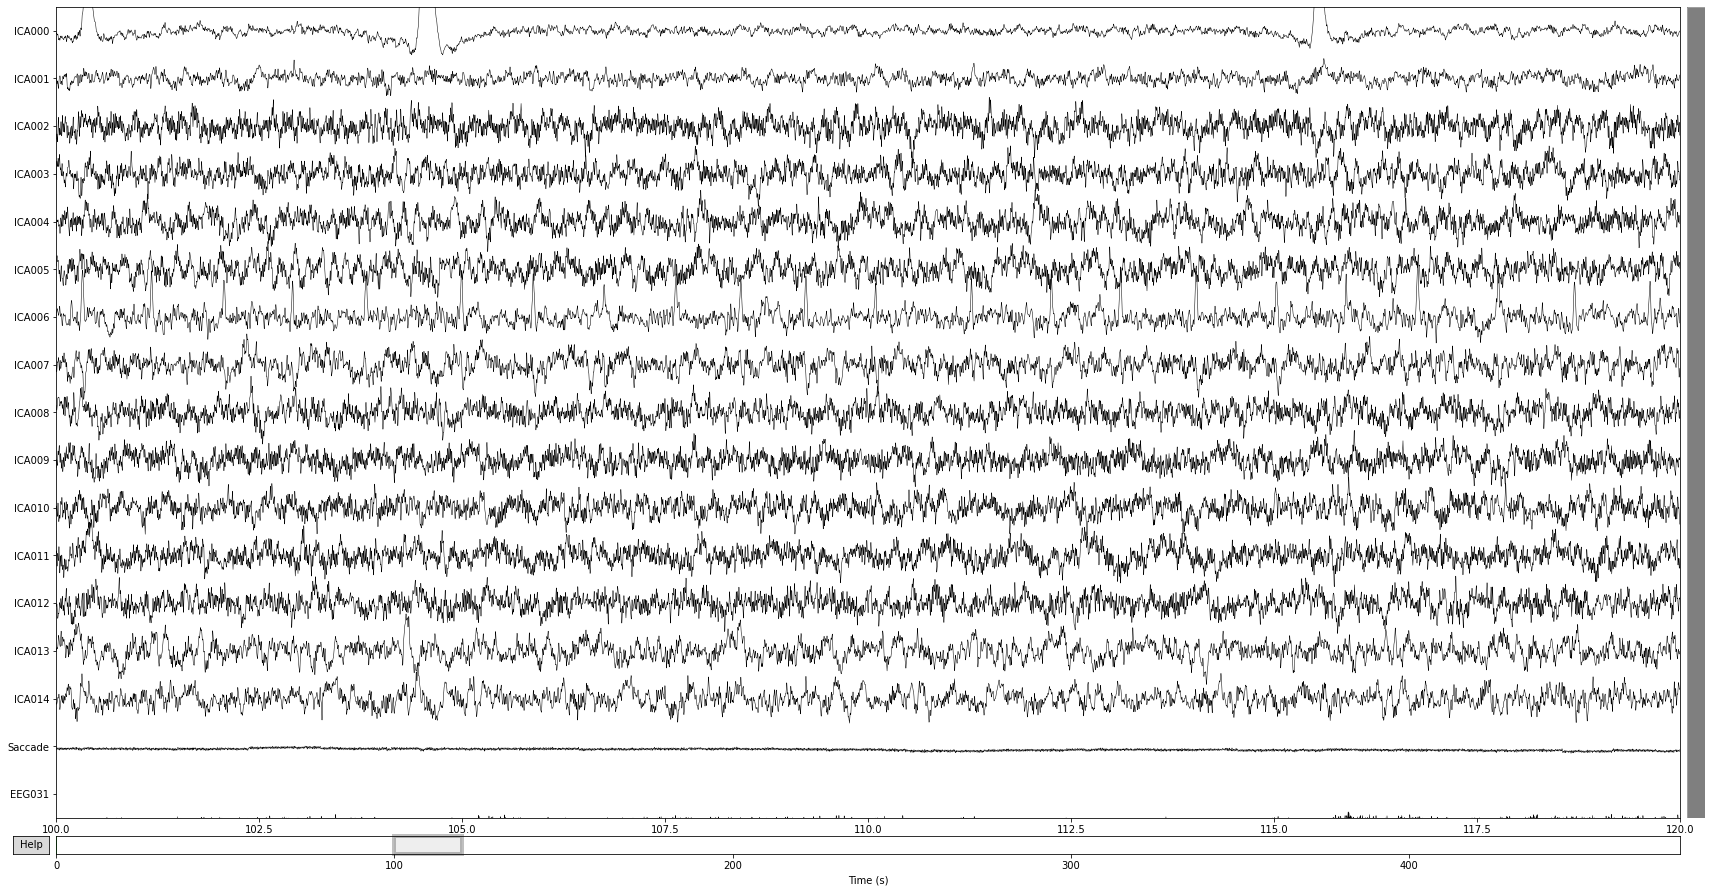

In [249]:
# Plot all ica components as topomaps and their respective time course contributions
ica.plot_components()
ica.plot_sources(filter_raw, start=100);

### From these two plots we can infer that component 0 likely reflects saccades, component 1 blinks and component 3 QRS cycles/heartbeats: 

### 1) Comp 0 has a bipolar distribution with negative and positive poles outside of the head on the left and right in front of the eyes. Time course looks a little more like blinks. 

### 2) Comp 1 shows a negative pole right in front of the eyes (other pole likely below). 

### 3) Comp 6 time course has sharp, large peaks with small ripples surrounding them (QRS like shape). The topography shows a negative-positive split across the head as typical for heartbeat artifacts.

Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 1 ICA component
    Projecting back using 155 PCA components


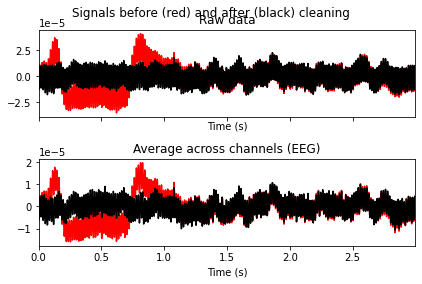

Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 1 ICA component
    Projecting back using 155 PCA components


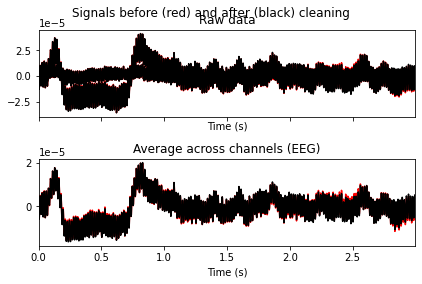

Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 1 ICA component
    Projecting back using 155 PCA components


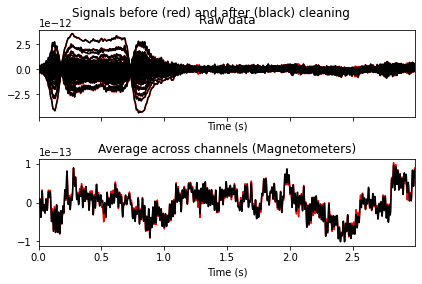

In [256]:
# We can plot the back-projected data excluding these components on the filtered raw signal with those components
# Here, black shows the signal after back-projection and red before

# Saccades on EEG (the red part clearly shows we'd be removing 
# typical step-like deflections due horizontal eye movements)
ica.plot_overlay(filter_raw, exclude=[0], picks='eeg');
# Blinks on EEG
ica.plot_overlay(filter_raw, exclude=[1], picks='eeg');
# Heartbeats on MEG
ica.plot_overlay(filter_raw, exclude=[6], picks='mag');

    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
Not setting metadata
240 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Not setting metadata
Not setting metadata
240 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Not setting metadata
Not setting metadata
240 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


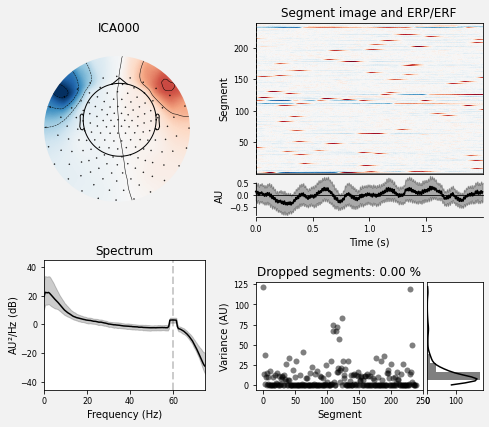

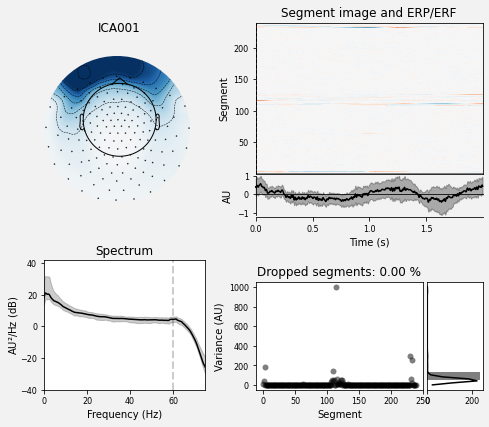

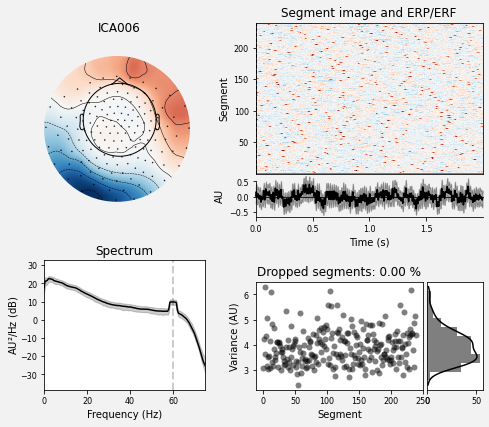

[<Figure size 504x432 with 6 Axes>,
 <Figure size 504x432 with 6 Axes>,
 <Figure size 504x432 with 6 Axes>]

In [251]:
# To be sure, we can look at exact details of these components
ica.plot_properties(filter_raw, picks=[0, 1, 6])

Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 3 ICA components
    Projecting back using 155 PCA components


C:\Users\Malte\Anaconda2\envs\mne\lib\site-packages\matplotlib\colors.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  c = np.array(c)


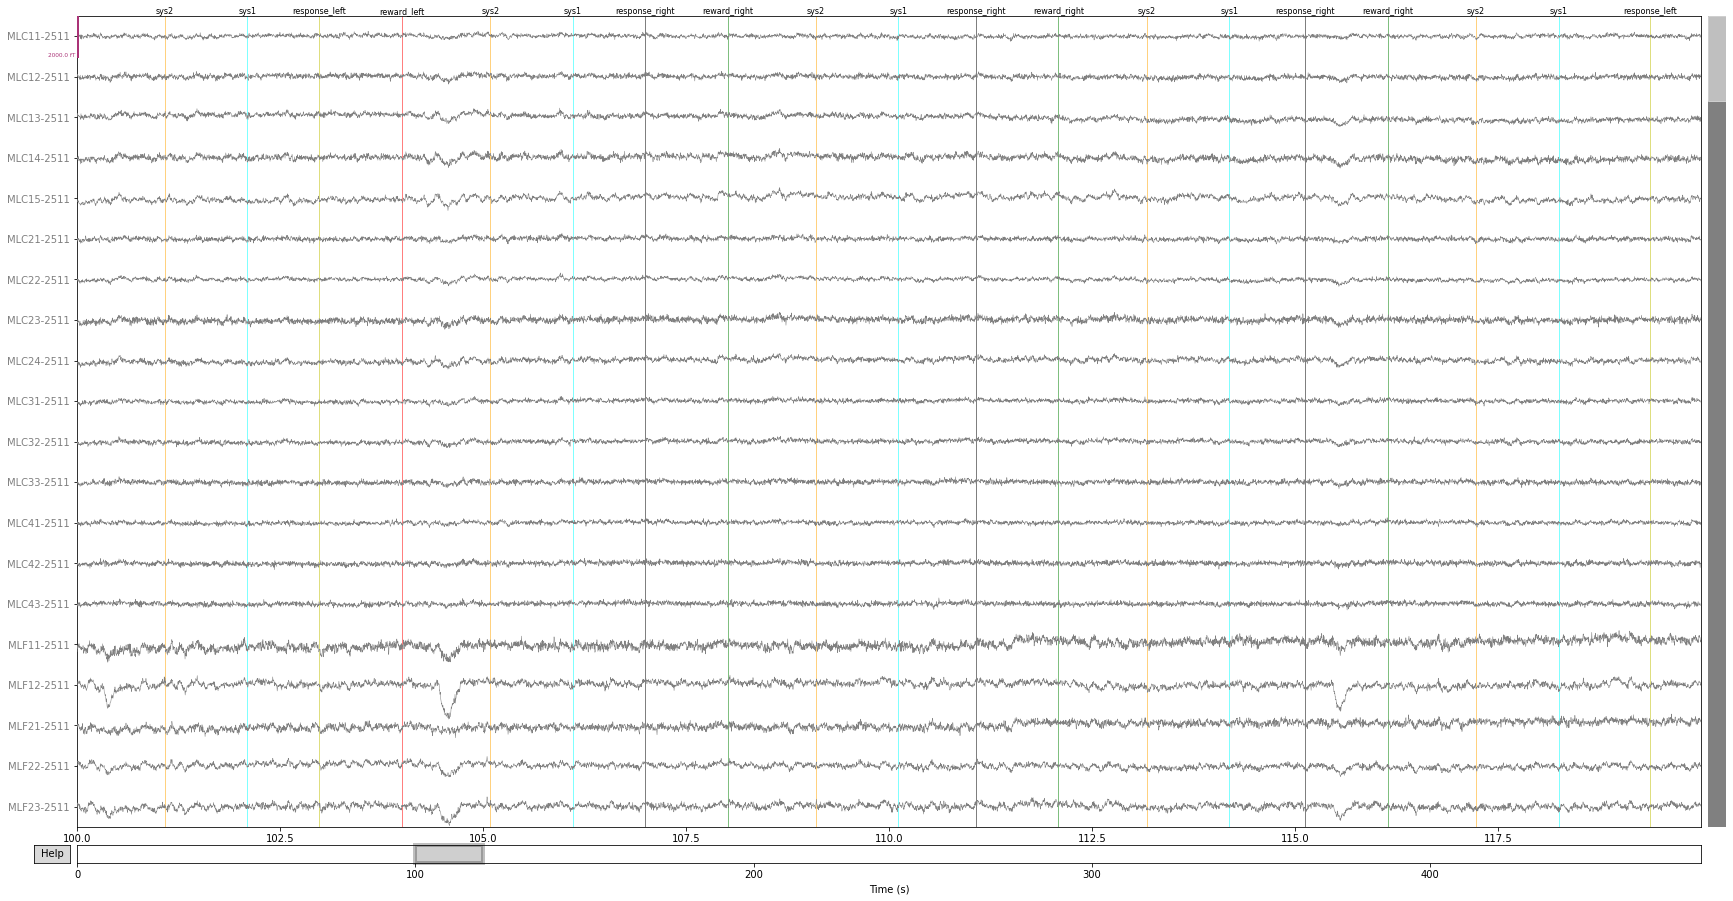

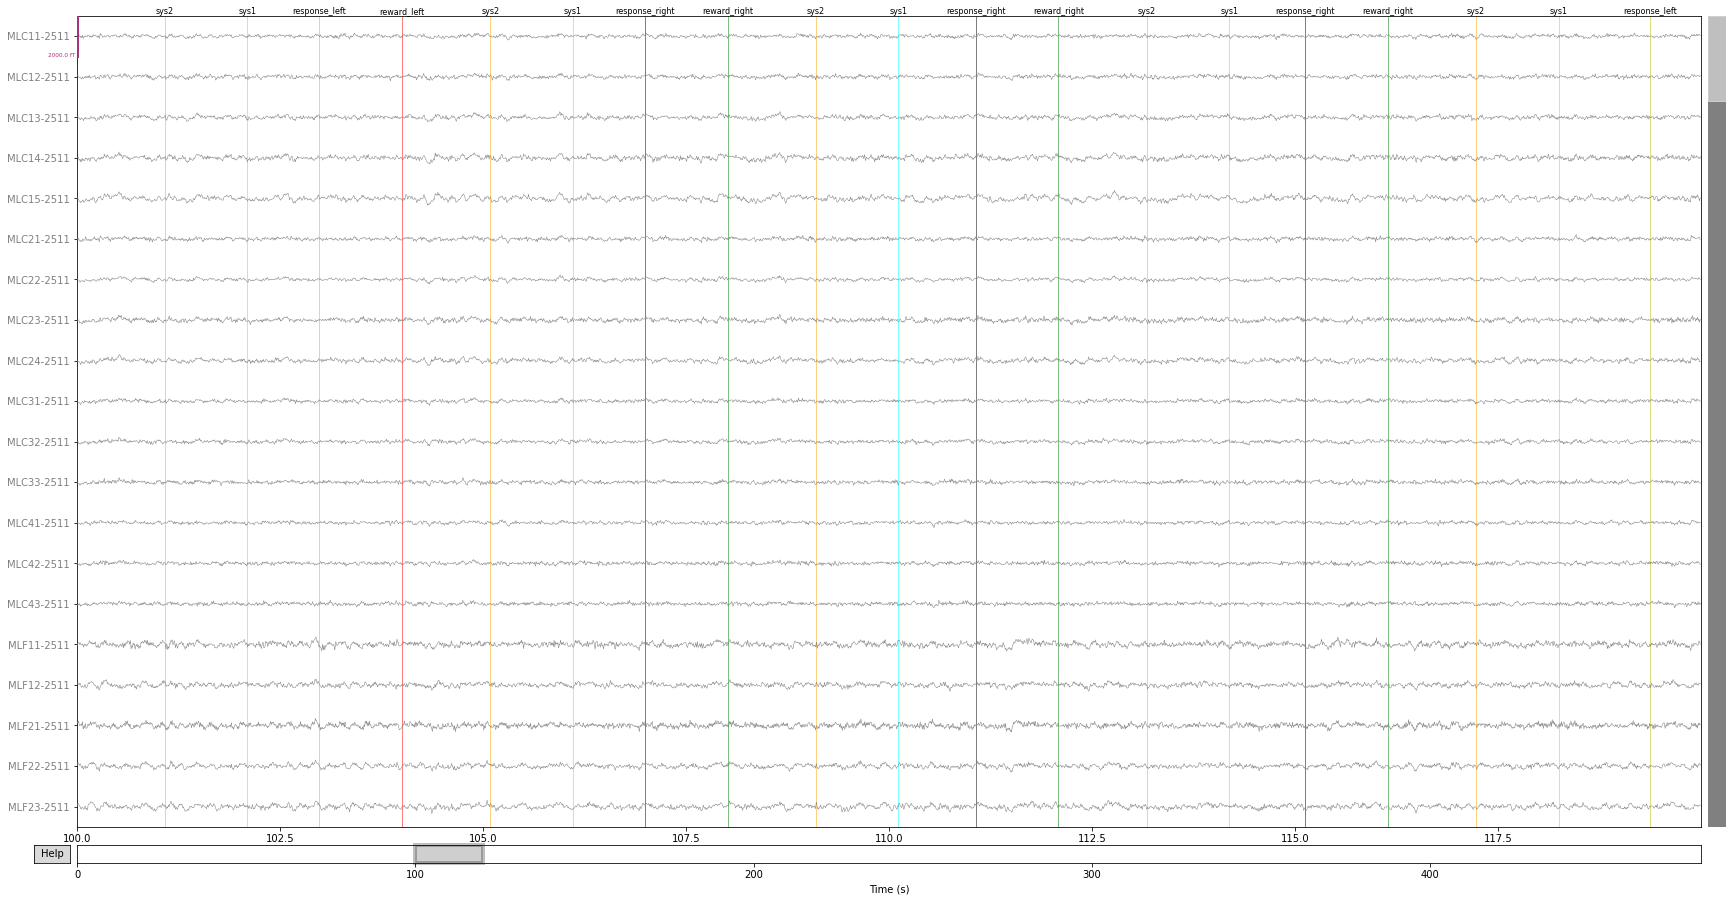

In [257]:
# Now we can remove these components before back-projecting the components to continuous data
ica.exclude = [0,1,6]

# Look at the raw data again after filtering and ICA
reconst_raw = filter_raw.copy()
ica.apply(reconst_raw)

raw.plot(events=events, start=100, duration=20, color='gray', event_id=event_id, scalings=dict(mag=1e-12, eeg=20e-6),
                event_color={589824: 'r', 524288: 'g', 458752: 'b', 393216: 'm', 327680: 'y', 262144: 'k',
                             131072: 'cyan', 65536: 'orange'});
reconst_raw.plot(events=events, start=100, duration=20, color='gray', event_id=event_id, scalings=dict(mag=1e-12, eeg=20e-6),
                event_color={589824: 'r', 524288: 'g', 458752: 'b', 393216: 'm', 327680: 'y', 262144: 'k',
                             131072: 'cyan', 65536: 'orange'});

In [258]:
# The same procedure can be applied using an automatic detection ICA-approach
# Build an empty list for component indices to be excluded
ica.exclude = []

# Test which components match the EOG pattern
eog_indices, eog_scores = ica.find_bads_eog(raw)
ica.exclude = eog_indices

... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 6000 samples (10.000 sec)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 6000 s

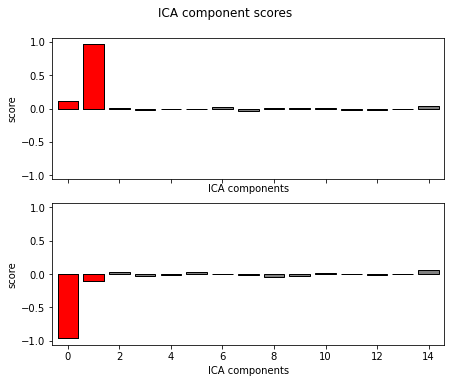

    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
Not setting metadata
240 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Not setting metadata
Not setting metadata
240 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


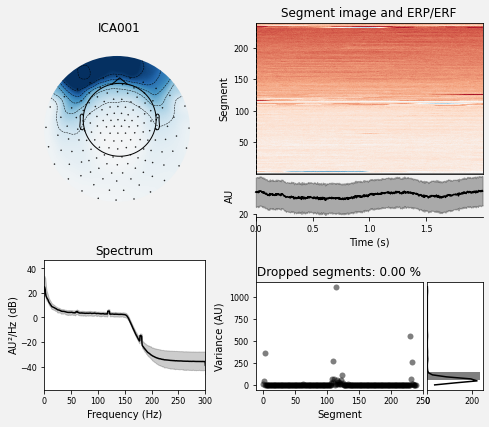

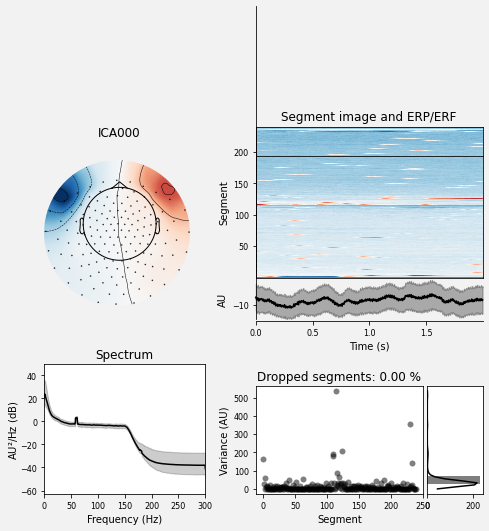

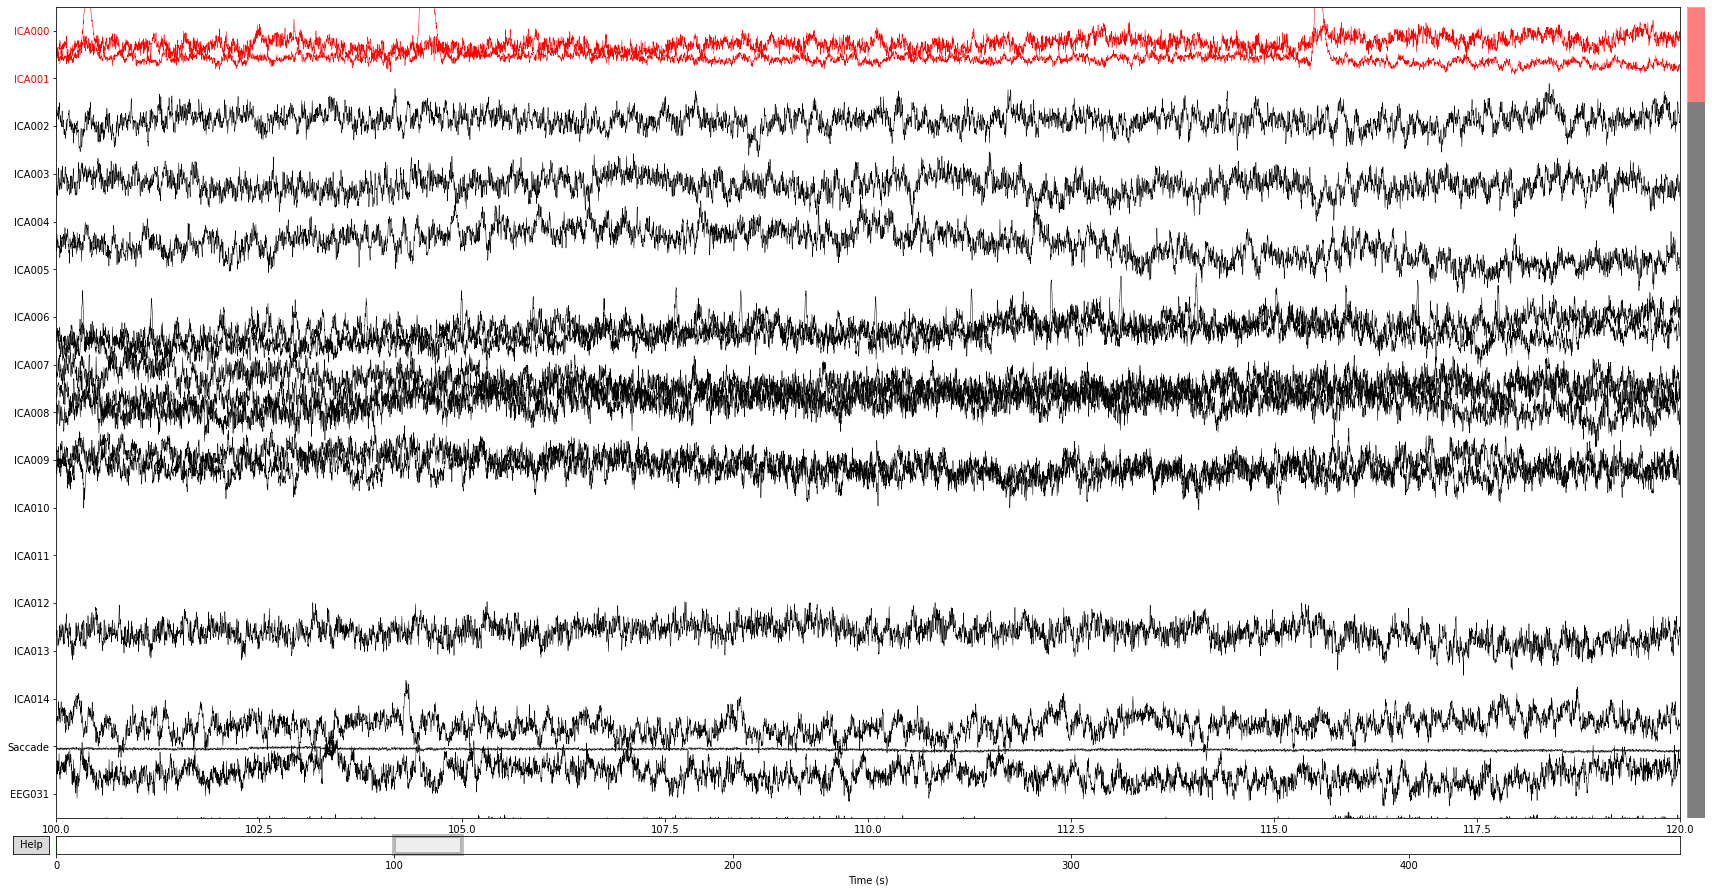

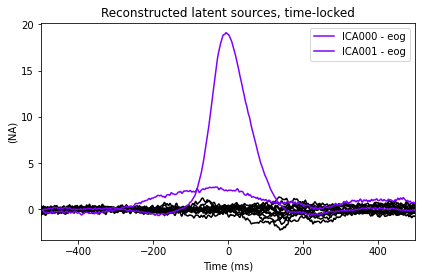

In [262]:
# Plot the component artifact scores along with component properties and averaged raw data around EOG events with the best matching component excluded
ica.plot_scores(eog_scores);
ica.plot_properties(raw, picks=eog_indices);
ica.plot_sources(raw, start=100);
ica.plot_sources(eog_epochs.average());

## Just for fun, we can rereference (only EEG data) and segment feedbacks to create an ERP

In [263]:
# Rereference to the mastoids
reconst_raw.set_eeg_reference(ref_channels=['M1', 'M2'])
# Segment the data
epochs = mne.Epochs(reconst_raw, events, event_id, tmin=-.2, tmax=.8, baseline=None)

EEG channel type selected for re-referencing
Applying a custom EEG reference.
Not setting metadata
Not setting metadata
400 matching events found
No baseline correction applied
0 projection items activated


In [264]:
# Average reward and no reward segments
reward = epochs['reward_left', 'reward_right'].average()
noreward = epochs['noreward_left', 'noreward_right'].average()

Applying baseline correction (mode: mean)
No projector specified for this dataset. Please consider the method self.add_proj.
Removing 5 compensators from info because not all compensation channels were picked.


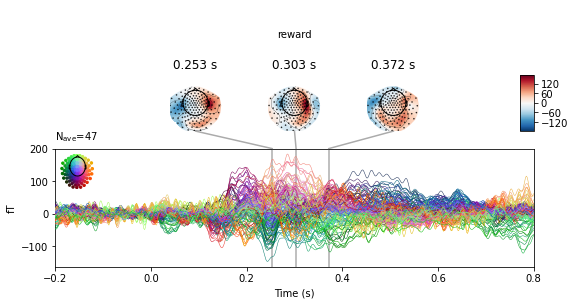

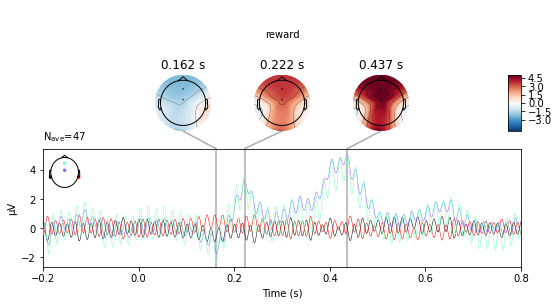

Applying baseline correction (mode: mean)
No projector specified for this dataset. Please consider the method self.add_proj.
Removing 5 compensators from info because not all compensation channels were picked.


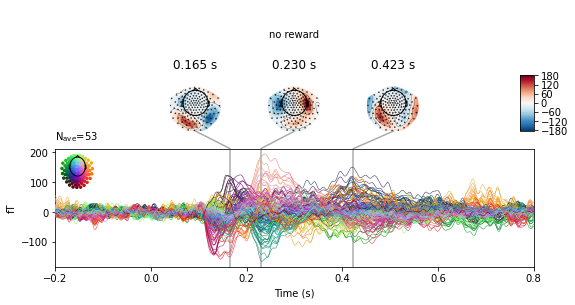

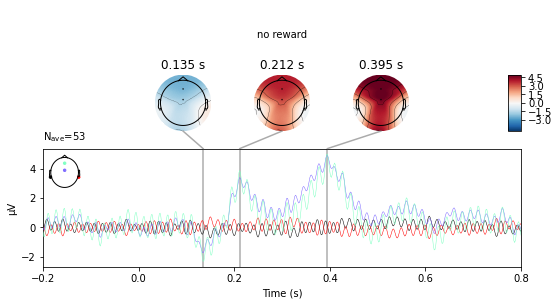

[<Figure size 576x302.4 with 7 Axes>, <Figure size 576x302.4 with 7 Axes>]

In [265]:
# Plot the baseline corrected (-100 ms to 0 ms) subject average
reward.apply_baseline(baseline=[-.1,0]).plot_joint(title='reward')
noreward.apply_baseline(baseline=[-.1,0]).plot_joint(title='no reward')

# Or a very quick-and-dirty time-frequency analysis

Not setting metadata
Not setting metadata
400 matching events found
No baseline correction applied
0 projection items activated
Loading data for 53 events and 3001 original time points ...
0 bad epochs dropped
    Using multitaper spectrum estimation with 7 DPSS windows


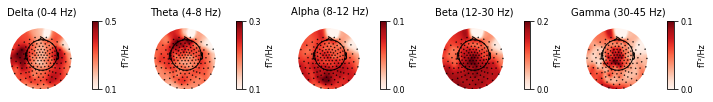

In [285]:
# Here is the general distribution of power spectral density across bands
epochs = mne.Epochs(reconst_raw, events, event_id, tmin=-2.5, tmax=2.5, baseline=None) 
epochs['noreward_left', 'noreward_right'].plot_psd_topomap(ch_type='mag', normalize=True);

In [269]:
# Define the analysis parameters (frequencies, cycles, etc)
freqs = np.linspace(1, 50, num=50)
n_cycles = 3
power, itc = tfr_morlet(epochs['noreward_left', 'noreward_right'], 
                        freqs=freqs, n_cycles=n_cycles, use_fft=True,
                        return_itc=True, decim=3, n_jobs=1)

Loading data for 53 events and 3001 original time points ...
0 bad epochs dropped


Applying baseline correction (mode: mean)


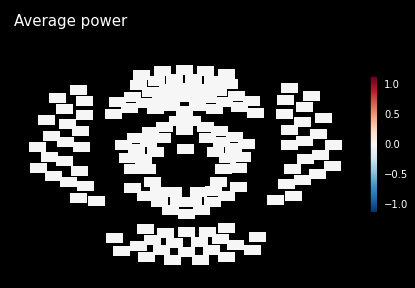

Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)


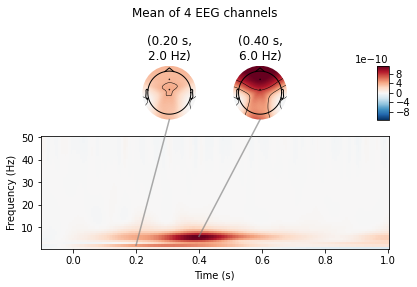

Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)


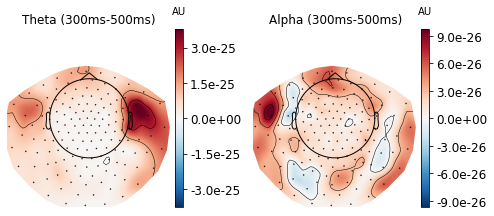

In [288]:
power.plot_topo(baseline=(-0.1, 0), mode='mean', title='Average power')

power.plot_joint(baseline=(-0.1, 0), mode='mean', tmin=-.1, tmax=1, picks=picks_eeg.ch_names,
                 timefreqs=[(.2, 2), (.4, 6)])

fig, axis = plt.subplots(1, 2, figsize=(7, 4))
power.plot_topomap(ch_type='mag', tmin=0.3, tmax=0.5, fmin=4, fmax=8,
                   baseline=(-0.1, 0), mode='mean', axes=axis[0],
                   title='Theta (300ms-500ms)', show=False)
power.plot_topomap(ch_type='mag', tmin=0.3, tmax=0.5, fmin=9, fmax=12,
                   baseline=(-0.1, 0), mode='mean', axes=axis[1],
                   title='Alpha (300ms-500ms)', show=False)

mne.viz.tight_layout()
plt.show()